## pitchfork_review_anlaysis
**Program:** 01_pitchfork_review_analysis.ipynb <br>
**Created by:** Chris Chan<br>
**Date:** Mar 16, 2021<br>
**Purpose:** <br>
. The purpose of the project is to develop a modern jazz artist recommender/discovery based on sub-genres or non-jazz artists somehow linked to the jazz album via pitchfork review text. Upon inspection of reviews (namely jazz reviews) there is high chance of other non-jazz artist referenced to shed light on some similarity. The idea is to take these links as features or search terms in a rec system that would link to the jazz artist. The jazz artists would be cmpared as well given various topics modeled from all of the reviews.

. 1. bring in data, count vectorize, etc. <br>
. 2. preprocessing - clean, lemmatize <br>
. 3. explore:<br>
    . Basic EDA
    . try topic modeling<br>
    . sentiment analysis<br>
    . combining the two<br>

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF

In [2]:
import glob
import os
from collections import defaultdict
import re
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
import nltk
import os
import spacy
import re
import string
import pickle
from itertools import cycle
import matplotlib.pyplot as plt
from nltk import stem
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic, vis_topic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import scattertext as st

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

## Testing

In [2]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Build a dataframe with 4 connections
df = pd.DataFrame({ 'from':['A', 'B', 'C','A'], 'to':['D', 'A', 'E','C']})
df

,from,to
0,A,D
1,B,A
2,C,E
3,A,C


In [3]:
# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')

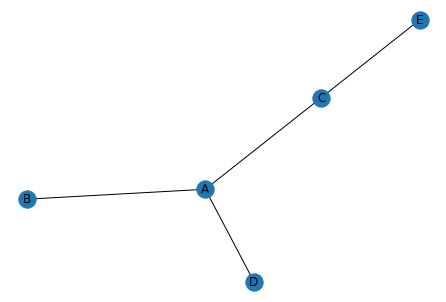

In [4]:
# Plot it
nx.draw(G, with_labels=True)
plt.show()

## Read in data

**We read through all the docments and build a list-of-list of words:**

In [121]:
df = pd.read_csv('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj5/data/pitchfork_jazz_clean.csv')

In [122]:
df.head()

,Unnamed: 0,artist,album,score,genre,review,othercat,othercat2,best,date,testing_formula
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","['Skip to content', 'All Results', 'Home', 'Ne...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,March 4 2021,"Skip to content, All Results, Home, News, Revi..."
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","['Skip to content', 'All Results', 'Home', 'Ne...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,February 20 2021,"Skip to content, All Results, Home, News, Revi..."
2,2,Archie Shepp / Jason Moran,Let My People Go,7.5,Jazz,These live sets between the saxophonist and pi...,"['Skip to content', 'All Results', 'Home', 'Ne...","Archie Shepp, Jason Moran, Madison Bloom, ...",0,February 15 2021,"Skip to content, All Results, Home, News, Revi..."
3,3,Patricia Brennan,Maquishti,7.4,Experimental,"Challenging but never chaotic, contemplative y...","['Skip to content', 'All Results', 'Home', 'Ne...","Patricia Brennan, Daniel Felsenthal, Experime...",0,January 19 2021,"Skip to content, All Results, Home, News, Revi..."
4,4,Baldi/Gerycz Duo,After Commodore Perry Service Plaza,7.1,Jazz,The second album of improvisational jazz from ...,"['Skip to content', 'All Results', 'Home', 'Ne...","Baldi/Gerycz Duo, Fred Thomas, Experimental,...",0,January 6 2021,"Skip to content, All Results, Home, News, Revi..."


In [123]:
nonwords=['Skip to content', 'All Results', 'Home', 'News', 'Reviews', 'Albums', 'Tracks', 'Sunday Reviews', '8.0+ Reviews',
          'Best New Music', 'Features', 'Lists & Guides', 'Longform', 'Rising', 'Photo Galleries', 'The Pitch', 'Video',
          'Over/Under', 'Liner Notes', 'Under the Influences', 'On the Records', 'Critical Breakthroughs', 'Podcast', 'GRAMMYS 2021',
          'Newsletter', 'Advertising', 'Masthead', 'Careers', 'Contact', 'Accessibility Help', 'More Pitchfork', 'Pitchfork Music Festival Chicago',
          'Pitchfork Music Festival Paris', 'Pitchfork Music Festival Berlin', 'Pitchfork Radio', 'Home     ', 
          'Staff Picks', 'Jazz', 'Bandcamp', 'Buy','8.0+ ','8.0+','Back to home']

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       624 non-null    int64  
 1   artist           624 non-null    object 
 2   album            623 non-null    object 
 3   score            615 non-null    float64
 4   genre            615 non-null    object 
 5   review           624 non-null    object 
 6   othercat         624 non-null    object 
 7   othercat2        615 non-null    object 
 8   best             624 non-null    int64  
 9   date             615 non-null    object 
 10  testing_formula  615 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 53.8+ KB


In [125]:
df.othercat2.value_counts()

 Miles Davis, Dominique Leone                                                                                                                                                                                                        5
 NOMO, Joe Tangari, Global,  Pop/R&B                                                                                                                                                                                                 4
 Capillary Action, Joe Tangari,  Rock                                                                                                                                                                                                3
 John Zorn, Dominique Leone, Experimental                                                                                                                                                                                            3
 Alog, Mark Richardson, Electronic,  Rock                                   

In [ ]:
# pat = r'\b(?:{})\b'.format('|'.join(nonwords))
# print(pat)
# #df['test'] = df['othercat'].replace("'","")
# df['othercat2'] = df['othercat'].str.replace(pat,'')
# df.head()

In [ ]:
# import re
# test=[re.sub('[^,a-zA-Z0-9]+', ' ', _) for _ in df['othercat2']]
# test

## Data Cleaning

In [126]:
breaks = lambda x: re.sub("\n", " ", x)
alphanumeric = lambda x: re.sub("\w*\d\w*", "", x)
punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "", x.lower())

In [130]:
df["review_clean"] = df["review"].map(breaks).map(alphanumeric).map(punc_lower)
df["othercat_clean"] = df["othercat2"].str.lower()
df["artist_clean"] = df["artist"].str.lower()
df["album_clean"] = df["album"].str.lower()

In [131]:
df.head(3)

,Unnamed: 0,artist,album,score,genre,review,othercat,othercat2,best,date,testing_formula,review_clean,othercat_clean,artist_clean,album_clean
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","['Skip to content', 'All Results', 'Home', 'Ne...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,March 4 2021,"Skip to content, All Results, Home, News, Revi...",fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","['Skip to content', 'All Results', 'Home', 'Ne...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,February 20 2021,"Skip to content, All Results, Home, News, Revi...",on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +
2,2,Archie Shepp / Jason Moran,Let My People Go,7.5,Jazz,These live sets between the saxophonist and pi...,"['Skip to content', 'All Results', 'Home', 'Ne...","Archie Shepp, Jason Moran, Madison Bloom, ...",0,February 15 2021,"Skip to content, All Results, Home, News, Revi...",these live sets between the saxophonist and pi...,"archie shepp, jason moran, madison bloom, ...",archie shepp / jason moran,let my people go


## Some EDA

In [132]:
df.describe()

,Unnamed: 0,score,best
count,624.000000,615.000000,624.000000
mean,311.500000,7.428618,0.070513
std,180.277564,1.157300,0.256215
min,0.000000,1.000000,0.000000
25%,155.750000,7.000000,0.000000
50%,311.500000,7.600000,0.000000
75%,467.250000,8.000000,0.000000
max,623.000000,10.000000,1.000000


In [134]:
df['revdate'] = pd.to_datetime(df['date'])

In [136]:
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat,othercat2,best,date,testing_formula,review_clean,othercat_clean,artist_clean,album_clean,revdate
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","['Skip to content', 'All Results', 'Home', 'Ne...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,March 4 2021,"Skip to content, All Results, Home, News, Revi...",fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","['Skip to content', 'All Results', 'Home', 'Ne...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,February 20 2021,"Skip to content, All Results, Home, News, Revi...",on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +,2021-02-20


### Scores over time

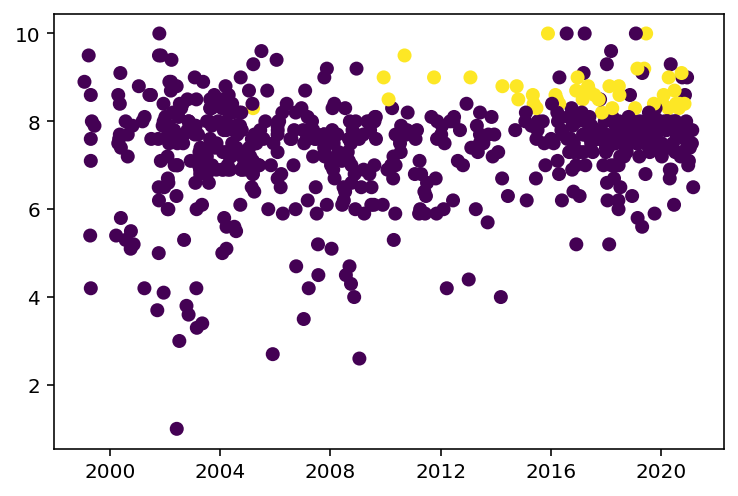

In [142]:
%matplotlib inline
plt.scatter(y='score',x='revdate',data=df,c='best')
plt.show()

### Stop Words

In [144]:
from sklearn.feature_extraction import text 

my_stop_words = nltk.corpus.stopwords.words('english')

### Lemmatize

In [145]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [146]:
df["review_lem"] = df["review"].apply(spacy_lemmatize)
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat,othercat2,best,date,testing_formula,review_clean,othercat_clean,artist_clean,album_clean,revdate,review_lem
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","['Skip to content', 'All Results', 'Home', 'Ne...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,March 4 2021,"Skip to content, All Results, Home, News, Revi...",fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04,"fifty - two track deep , this archival compend..."
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","['Skip to content', 'All Results', 'Home', 'Ne...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,February 20 2021,"Skip to content, All Results, Home, News, Revi...",on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +,2021-02-20,"on the duo ’s generation - span double album ,..."


In [148]:
df.review_lem[135]

'the Minneapolis synth - pop band team up with a Berlin - base orchestra in an attempt to reckon with the trial of our time . you have to admire Poliça ’s willingness to break their own mold . in 2016 , with two album \' worth of hazy breakup song under their belt , the Minneapolis five - piece abruptly pivot into political consciousness and trade some of their rock instinct in for a smattering of pop motif . the result album , United Crushers , falter at time , but it be a good - faith effort to engage with the national mood . Poliça read the room and respond accordingly . Poliça ’s late album be the product of another reinvention . in merge with s t a r g a z e , the Berlin - base orchestral collective lead by conductor André de Ridder , they ’ve more than double their lineup . with all those extra body in the room , the deep , dark chasm that fracture their early work , separate singer Channy Leaneagh ’s voice from producer Ryan Olson ’s rumble synth , begin to fill in . the result 